<a href="https://colab.research.google.com/github/cleodecker/tcc/blob/main/LCCNN_Hib_Brasil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# Notebook de Projeção de Mortalidade
# Modelo Híbrido Lee-Carter + LCNN com Intervalos de Confiança e Validação
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import resample
from scipy.stats import linregress
from statsmodels.tsa.api import SimpleExpSmoothing
from numpy.linalg import svd
import os
import warnings

# Configurações iniciais
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.6f' % x)
np.random.seed(42)
tf.random.set_seed(42)
plt.style.use('ggplot')

In [26]:
# Função para calcular sMAPE
def smape(y_true, y_pred):
    return 200 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))

# Função para preparar dados LCNN
def prepare_lcnn_data(k_t_series, window=10):
    X, y = [], []
    for i in range(len(k_t_series) - window):
        X.append(k_t_series[i:i+window])
        y.append(k_t_series[i+window])
    return np.array(X), np.array(y)

# Função para treinar modelo LCNN
def train_lcnn_model(X_train, y_train, epochs=150):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        Dropout(0.3),
        LSTM(100, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh'),
        Dense(30, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=['mae'])

    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    history = model.fit(
        X_train[..., np.newaxis], y_train,
        epochs=epochs,
        batch_size=16,
        validation_split=0.2,
        verbose=0,
        callbacks=[early_stop]
    )
    return model, history

# Função para ajustar modelo Lee-Carter
def fit_lee_carter(df_country):
    log_mx = df_country.pivot(index='Year', columns='Age', values='mx').apply(np.log)
    a_x = log_mx.mean(axis=0)
    Z = log_mx - a_x

    U, S, Vt = svd(Z, full_matrices=False)
    k_t = U[:, 0] * S[0]
    b_x = Vt[0, :]

    b_x = b_x / b_x.sum()
    k_t = k_t * b_x.sum()

    return a_x, b_x, k_t, log_mx.index, log_mx.columns

# Função para previsão passo a passo
def forecast_step_by_step(model, last_k_t, steps, window):
    k_forecast = []
    current_sequence = last_k_t[-window:].copy()
    for _ in range(steps):
        input_data = current_sequence.reshape(1, window, 1)
        next_pred = model.predict(input_data, verbose=0)[0, 0]
        k_forecast.append(next_pred)
        current_sequence = np.append(current_sequence[1:], next_pred)
    return np.array(k_forecast)

# Função para calcular métricas por idade
def calculate_age_metrics(actual, forecast, ages, test_years):
    metrics = []
    for i, age in enumerate(ages):
        y_true = actual[actual['Year'].isin(test_years) & (actual['Age'] == age)]['mx'].values
        y_pred = forecast[:, i]

        if len(y_true) != len(y_pred):
            y_pred = y_pred[:len(y_true)]

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        smape_val = smape(y_true, y_pred)

        metrics.append({
            'Age': age,
            'RMSE': rmse,
            'MAE': mae,
            'sMAPE': smape_val
        })
    return pd.DataFrame(metrics)

# Função para reforço de tendência
def reinforce_trend(k_t_hist, k_t_proj, strength=0.1):
    x_hist = np.arange(len(k_t_hist))
    slope, _, _, _ = linregress(x_hist, k_t_hist)
    return k_t_proj + strength * slope * np.arange(1, len(k_t_proj)+1)

# Função para suavização
def smooth_series(series, alpha=0.3):
    return SimpleExpSmoothing(series).fit(smoothing_level=alpha).fittedvalues

# Função para plotar projeções
def plot_projection(years_hist, k_t_hist, years_proj, k_t_proj, ci_lower, ci_upper, title):
    plt.figure(figsize=(10, 6))
    plt.plot(years_hist, k_t_hist, 'bo-', label='Histórico')
    plt.plot(years_proj, k_t_proj, 'r-', label='Projeção')
    plt.fill_between(years_proj, ci_lower, ci_upper, color='gray', alpha=0.3, label='IC 95%')
    plt.title(title)
    plt.xlabel('Ano')
    plt.ylabel('k_t')
    plt.grid(True)
    plt.legend()
    plt.savefig(f"{title.replace(' ', '_')}.png", dpi=300)
    plt.show()

# Função para plotar curvas de mortalidade
def plot_mortality_curves(ages, mx_forecast, years_proj, title):
    plt.figure(figsize=(10, 6))
    for year_idx in [0, len(years_proj)//2, len(years_proj)-1]:
        plt.semilogy(ages, mx_forecast[year_idx], label=f'{years_proj[year_idx]}')
    plt.title(title)
    plt.xlabel('Idade')
    plt.ylabel('log(mx)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{title.replace(' ', '_')}.png", dpi=300)
    plt.show()

# Função para gerar intervalos de confiança
def hybrid_forecast_with_ci(model, last_k_t, window, years_forecast=15, n_bootstraps=500):
    k_hybrid = last_k_t.copy()
    for _ in range(years_forecast):
        input_data = k_hybrid[-window:].reshape(1, window, 1)
        pred = model.predict(input_data, verbose=0)[0, 0]
        k_hybrid = np.append(k_hybrid, pred)

    bootstrap_samples = []
    for _ in range(n_bootstraps):
        sample = last_k_t.copy()
        noise = np.random.normal(0, np.std(np.diff(last_k_t))/10, size=len(last_k_t))
        sample += noise

        future = sample[-window:]
        for j in range(years_forecast):
            input_data = future[-window:].reshape(1, window, 1)
            pred = model.predict(input_data, verbose=0)[0, 0] + np.random.normal(0, np.std(np.diff(last_k_t))/10)
            future = np.append(future, pred)
        bootstrap_samples.append(future[-years_forecast:])

    ci_lower = np.percentile(bootstrap_samples, 2.5, axis=0)
    ci_upper = np.percentile(bootstrap_samples, 97.5, axis=0)

    return k_hybrid[-years_forecast:], ci_lower, ci_upper

# Função para calcular mx projetado
def calculate_mx(a_x, b_x, k_t_series):
    return np.exp(a_x.values + np.outer(k_t_series, b_x))

# Função para criar DataFrame de projeções
def create_projection_df(proj_years, ages, mx_forecast, gender, country_code):
    df_list = []
    for i, year in enumerate(proj_years):
        for j, age in enumerate(ages):
            df_list.append({
                'Country': country_code,
                'Year': year,
                'Gender': gender,
                'Age': age,
                'mx': mx_forecast[i, j]
            })
    return pd.DataFrame(df_list)

In [27]:
# =================================================================
# 1. CARREGAMENTO E PREPARAÇÃO DOS DADOS
# =================================================================
print("Carregando e preparando dados...")
# Carregar os dados
url = "https://raw.githubusercontent.com/cleodecker/tcc/main/df_all.csv"
cache_file = "df_all.csv"

if not os.path.exists(cache_file):
    df = pd.read_csv(url)
    df.to_csv(cache_file, index=False)
    print("Dataset baixado do GitHub e salvo em cache")
else:
    df = pd.read_csv(cache_file)
    print("Dataset carregado do cache local")
print(f'Dataset carregado: {df.shape}')
print(f'Colunas: {list(df.columns)}')
print(f'\nPrimeiras linhas:')
print(df.head())

# Renomear coluna de idade 0
df = df.rename(columns={'0': 'Age_0'})

# Verificar estrutura
print(f"Dimensões: {df.shape[0]} linhas, {df.shape[1]} colunas")
print(f"Países: {df['Country'].unique()}")
print(f"Anos: {df['Year'].min()} - {df['Year'].max()}")
print(f"Gênero: {df['Gender'].unique()}")  # Todos 0 (agregado)

# Dados faltantes?
print(f"Dados faltantes: {df.isnull().sum().sum()}")

# Organizar dados em formato longo
id_vars = ['Country', 'Year', 'Gender']
age_columns = ['Age_0', '1', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80', '85', '90']

df_long = df.melt(
    id_vars=id_vars,
    value_vars=age_columns,
    var_name='Age',
    value_name='mx'
)

# Converter idade para numérico
df_long['Age'] = df_long['Age'].replace({'Age_0': 0}).astype(int)
df_long = df_long.sort_values(['Country', 'Year', 'Age'])

# Separar homens e mulheres
df_long_m = df_long[df_long['Gender'] == 0]
df_long_f = df_long[df_long['Gender'] == 1]

# Filtrar para Brasil (código 49)
country_code = 49
country_m = df_long_m[df_long_m['Country'] == country_code]
country_f = df_long_f[df_long_f['Country'] == country_code]

Carregando e preparando dados...
Dataset carregado do cache local
Dataset carregado: (7744, 23)
Colunas: ['Country', 'Year', '0', '1', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80', '85', '90', 'Gender']

Primeiras linhas:
   Country  Year        0        1        5       10       15       20  \
0        0  1950 0.028360 0.001820 0.000890 0.000760 0.001380 0.002060   
1        0  1951 0.028320 0.001890 0.000810 0.000770 0.001690 0.002230   
2        0  1952 0.027910 0.001710 0.000690 0.000640 0.001560 0.002030   
3        0  1953 0.026320 0.001700 0.000760 0.000690 0.001530 0.001890   
4        0  1954 0.025580 0.001760 0.000640 0.000620 0.001460 0.001830   

        25       30       35       40       45       50       55       60  \
0 0.001640 0.001880 0.002530 0.003990 0.006490 0.010970 0.017360 0.027670   
1 0.001830 0.001930 0.002710 0.003990 0.006600 0.011250 0.018430 0.028880   
2 0.001850 0.001880 0.002620 0.003860 0.006670 0.0112

Realizando análise exploratória...


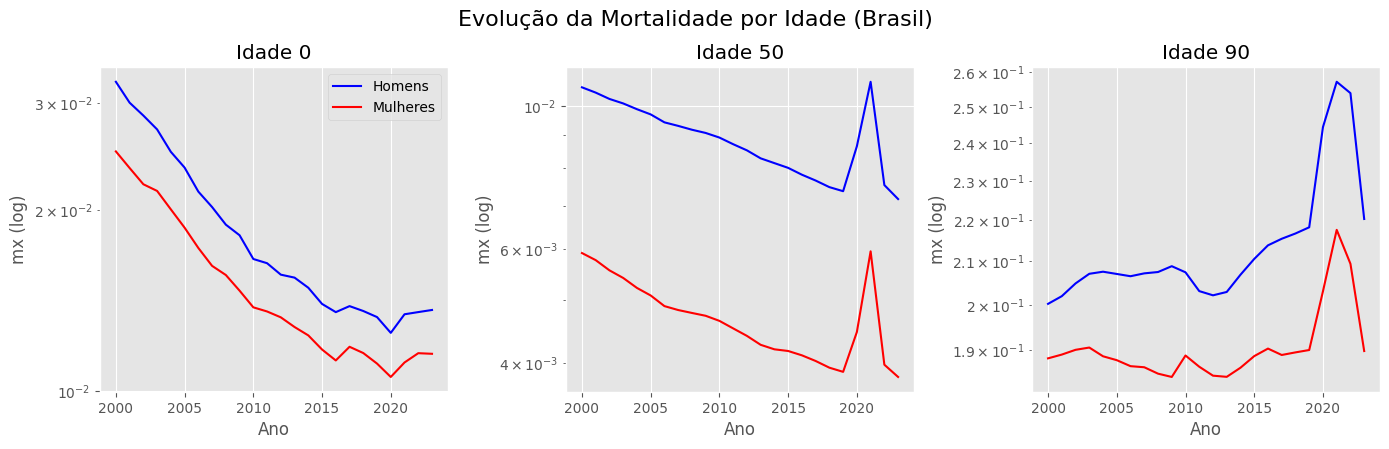

In [29]:
# =================================================================
# 2. ANÁLISE EXPLORATÓRIA
# =================================================================
print("Realizando análise exploratória...")
plt.figure(figsize=(14, 8))

# Mortalidade por ano para idades selecionadas
for i, age in enumerate([0, 50, 90]):
    plt.subplot(2, 3, i+1)
    subset_m = country_m[country_m['Age'] == age]
    subset_f = country_f[country_f['Age'] == age]
    plt.plot(subset_m['Year'], subset_m['mx'], 'b-', label='Homens')
    plt.plot(subset_f['Year'], subset_f['mx'], 'r-', label='Mulheres')
    plt.title(f'Idade {age}')
    plt.xlabel('Ano')
    plt.ylabel('mx (log)')
    plt.yscale('log')
    plt.grid(True)
    if i == 0:
        plt.legend()

plt.suptitle('Evolução da Mortalidade por Idade (Brasil)', fontsize=16)
plt.tight_layout()
plt.savefig('evolucao_mortalidade_por_idade.png', dpi=300)
plt.show()

Ajustando modelo Lee-Carter...


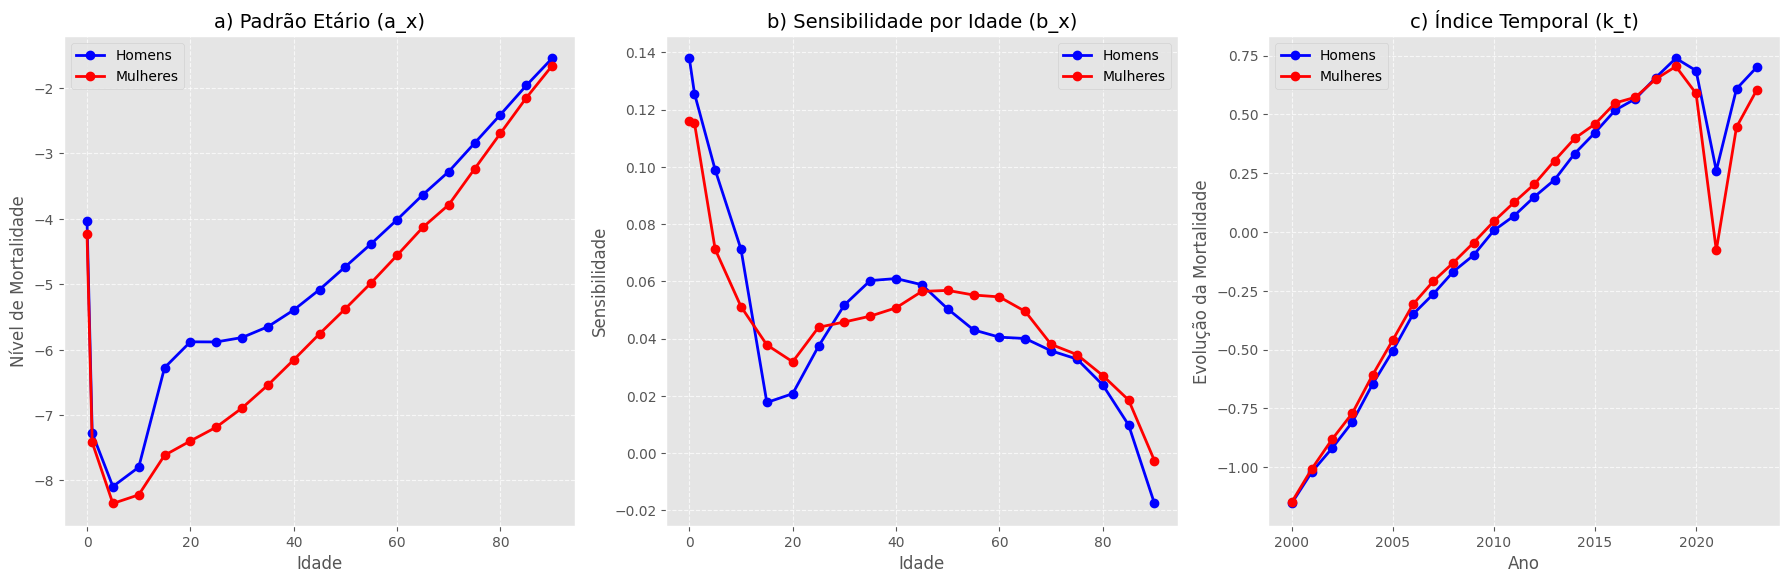

In [40]:
# =================================================================
# 3. MODELO LEE-CARTER
# =================================================================
print("Ajustando modelo Lee-Carter...")

# Filtrar anos comuns para ambos os sexos
common_years = sorted(set(country_m['Year']) & set(country_f['Year']))
country_m_filtered = country_m[country_m['Year'].isin(common_years)]
country_f_filtered = country_f[country_f['Year'].isin(common_years)]

# Ajustar modelo para homens
a_x_m, b_x_m, k_t_m, years_m_lc, ages_m_lc = fit_lee_carter(country_m_filtered)

# Ajustar modelo para mulheres
a_x_f, b_x_f, k_t_f, years_f_lc, ages_f_lc = fit_lee_carter(country_f_filtered)

# Visualizar parâmetros em 3 gráficos separados
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Gráfico 1: ax (padrão etário)
axes[0].plot(ages_m_lc, a_x_m.values, 'b-', marker='o', label='Homens', linewidth=2)
axes[0].plot(ages_f_lc, a_x_f.values, 'r-', marker='o', label='Mulheres', linewidth=2)
axes[0].set_title('a) Padrão Etário (a_x)', fontsize=14)
axes[0].set_xlabel('Idade')
axes[0].set_ylabel('Nível de Mortalidade')
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend()

# Gráfico 2: bx (sensibilidade etária)
axes[1].plot(ages_m_lc, b_x_m, 'b-', marker='o', label='Homens', linewidth=2)
axes[1].plot(ages_f_lc, b_x_f, 'r-', marker='o', label='Mulheres', linewidth=2)
axes[1].set_title('b) Sensibilidade por Idade (b_x)', fontsize=14)
axes[1].set_xlabel('Idade')
axes[1].set_ylabel('Sensibilidade')
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend()

# Gráfico 3: kt (índice temporal)
axes[2].plot(years_m_lc, k_t_m, 'b-', marker='o', label='Homens', linewidth=2)
axes[2].plot(years_f_lc, k_t_f, 'r-', marker='o', label='Mulheres', linewidth=2)
axes[2].set_title('c) Índice Temporal (k_t)', fontsize=14)
axes[2].set_xlabel('Ano')
axes[2].set_ylabel('Evolução da Mortalidade')
axes[2].grid(True, linestyle='--', alpha=0.7)
axes[2].legend()

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig('parametros_lee_carter_consolidado.png', dpi=300, bbox_inches='tight')
plt.show()

Treinando modelo híbrido Lee-Carter + LCNN...


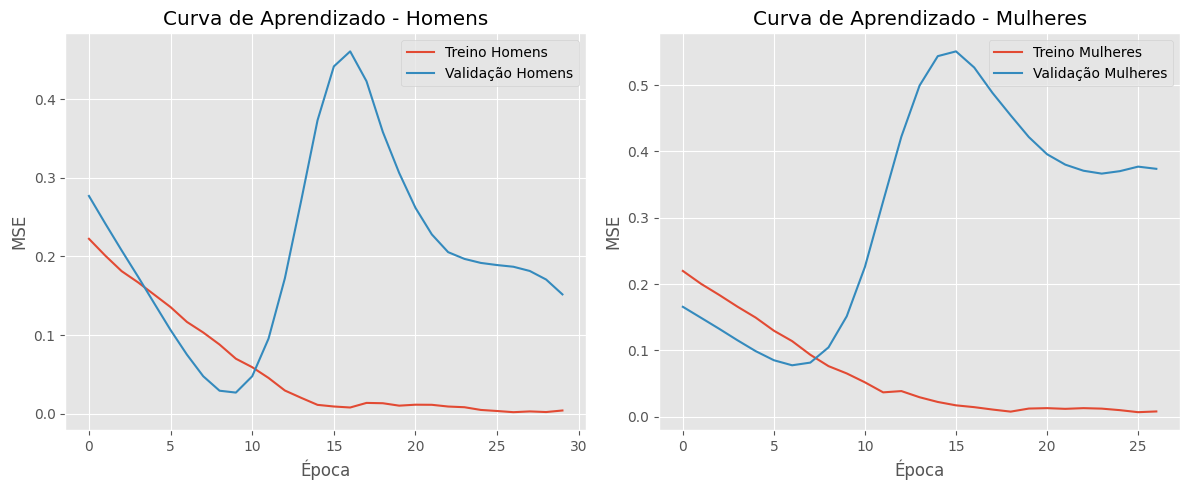

In [43]:
# =================================================================
# 4. MODELO HÍBRIDO LEE-CARTER + LCNN
# =================================================================
print("Treinando modelo híbrido Lee-Carter + LCNN...")
window_size = 10

# Homens
X_m, y_m = prepare_lcnn_data(k_t_m, window=window_size)
model_m, history_m = train_lcnn_model(X_m, y_m)

# Mulheres
X_f, y_f = prepare_lcnn_data(k_t_f, window=window_size)
model_f, history_f = train_lcnn_model(X_f, y_f)

# Curvas de aprendizado
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_m.history['loss'], label='Treino Homens')
plt.plot(history_m.history['val_loss'], label='Validação Homens')
plt.title('Curva de Aprendizado - Homens')
plt.ylabel('MSE')
plt.xlabel('Época')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_f.history['loss'], label='Treino Mulheres')
plt.plot(history_f.history['val_loss'], label='Validação Mulheres')
plt.title('Curva de Aprendizado - Mulheres')
plt.ylabel('MSE')
plt.xlabel('Época')
plt.legend()

plt.tight_layout()
plt.savefig('curvas_aprendizado.png', dpi=300)
plt.show()

In [46]:
# =================================================================
# 5. VALIDAÇÃO (PERÍODO 2015-2019)
# =================================================================
print("Realizando validação no período 2015-2019...")
test_years = list(range(2015, 2020))
train_end_year = 2014

# Homens - Re-treinar com dados até 2014
country_m_train = country_m[country_m['Year'] <= train_end_year]
a_x_m_train, b_x_m_train, k_t_m_train, years_m_train, ages_m_train = fit_lee_carter(country_m_train)
X_m_train, y_m_train = prepare_lcnn_data(k_t_m_train, window=window_size)
model_m_train, _ = train_lcnn_model(X_m_train, y_m_train, epochs=150)
k_t_m_forecast = forecast_step_by_step(model_m_train, k_t_m_train, steps=len(test_years), window=window_size)
mx_m_forecast = np.exp(a_x_m_train.values + np.outer(k_t_m_forecast, b_x_m_train))

# Mulheres - Re-treinar com dados até 2014
country_f_train = country_f[country_f['Year'] <= train_end_year]
a_x_f_train, b_x_f_train, k_t_f_train, years_f_train, ages_f_train = fit_lee_carter(country_f_train)
X_f_train, y_f_train = prepare_lcnn_data(k_t_f_train, window=window_size)
model_f_train, _ = train_lcnn_model(X_f_train, y_f_train, epochs=150)
k_t_f_forecast = forecast_step_by_step(model_f_train, k_t_f_train, steps=len(test_years), window=window_size)
mx_f_forecast = np.exp(a_x_f_train.values + np.outer(k_t_f_forecast, b_x_f_train))

# Calcular métricas
actual_m_test = country_m[country_m['Year'].isin(test_years)]
metrics_m = calculate_age_metrics(actual_m_test, mx_m_forecast, ages_m_train, test_years)
metrics_m['Sexo'] = 'Homem'
metrics_m['Local'] = 'Brasil'

actual_f_test = country_f[country_f['Year'].isin(test_years)]
metrics_f = calculate_age_metrics(actual_f_test, mx_f_forecast, ages_f_train, test_years)
metrics_f['Sexo'] = 'Mulher'
metrics_f['Local'] = 'Brasil'

# Combinar e salvar métricas
final_metrics = pd.concat([metrics_m, metrics_f], ignore_index=True)
final_metrics = final_metrics.rename(columns={'Age': 'Grupo Etário'})
final_metrics = final_metrics[['Local', 'Sexo', 'Grupo Etário', 'RMSE', 'sMAPE', 'MAE']]
final_metrics.to_csv('metricas_mortalidade_brasil_pre_covid.csv', index=False, float_format='%.6f')

print("Métricas de validação salvas em 'metricas_mortalidade_brasil_pre_covid.csv'")

Realizando validação no período 2015-2019...
Métricas de validação salvas em 'metricas_mortalidade_brasil_pre_covid.csv'


In [48]:
# =================================================================
# 6. PROJEÇÕES (2020-2070)
# =================================================================
print("Gerando projeções para 2020-2070...")
years_forecast = 51
proj_years = list(range(2020, 2020 + years_forecast))

# Homens
k_t_hybrid_m, ci_lower_m, ci_upper_m = hybrid_forecast_with_ci(
    model_m, k_t_m, window_size, years_forecast
)
k_t_reinforced_m = reinforce_trend(k_t_m, k_t_hybrid_m, strength=0.15)
k_t_smoothed_m = smooth_series(k_t_reinforced_m, alpha=0.2)
mx_forecast_m = calculate_mx(a_x_m, b_x_m, k_t_smoothed_m)

# Mulheres
k_t_hybrid_f, ci_lower_f, ci_upper_f = hybrid_forecast_with_ci(
    model_f, k_t_f, window_size, years_forecast
)
k_t_reinforced_f = reinforce_trend(k_t_f, k_t_hybrid_f, strength=0.15)
k_t_smoothed_f = smooth_series(k_t_reinforced_f, alpha=0.2)
mx_forecast_f = calculate_mx(a_x_f, b_x_f, k_t_smoothed_f)

# Visualizar projeções k_t
plot_projection(years_m_lc, k_t_m, proj_years, k_t_smoothed_m,
                ci_lower_m, ci_upper_m, 'Projeção k_t - Homens (Brasil)')

plot_projection(years_f_lc, k_t_f, proj_years, k_t_smoothed_f,
                ci_lower_f, ci_upper_f, 'Projeção k_t - Mulheres (Brasil)')

# Visualizar curvas de mortalidade projetadas
plot_mortality_curves(ages_m_lc, mx_forecast_m, proj_years,
                      'Curvas de Mortalidade Projetadas - Homens')

plot_mortality_curves(ages_f_lc, mx_forecast_f, proj_years,
                      'Curvas de Mortalidade Projetadas - Mulheres')

Gerando projeções para 2020-2070...


KeyboardInterrupt: 

In [ ]:
# =================================================================
# 7. EXPORTAÇÃO DOS RESULTADOS
# =================================================================
print("Exportando resultados...")
# Criar DataFrames de projeções
proj_m = create_projection_df(proj_years, ages_m, mx_forecast_m, 0, country_code)
proj_f = create_projection_df(proj_years, ages_f, mx_forecast_f, 1, country_code)

# Juntar e salvar
proj_all = pd.concat([proj_m, proj_f])
proj_all.to_csv(f'projecoes_mortalidade_brasil_{proj_years[0]}_{proj_years[-1]}.csv', index=False)

print(f"Projeções salvas em 'projecoes_mortalidade_brasil_{proj_years[0]}_{proj_years[-1]}.csv'")

In [ ]:
# =================================================================
# 8. RESULTADOS FINAIS
# =================================================================
print("\n" + "="*80)
print("RESUMO DA EXECUÇÃO")
print("="*80)
print(f"- Período histórico: {df['Year'].min()}-{df['Year'].max()}")
print(f"- Período de validação: 2015-2019")
print(f"- Período projetado: {proj_years[0]}-{proj_years[-1]}")
print(f"- Arquivos gerados:")
print(f"  1. metricas_mortalidade_brasil_pre_covid.csv (métricas de validação)")
print(f"  2. projecoes_mortalidade_brasil_{proj_years[0]}_{proj_years[-1]}.csv (projeções)")
print(f"  3. Vários gráficos de análise e resultados")

# Mostrar métricas resumidas
print("\nMétricas de Validação (Média por Sexo):")
print(final_metrics.groupby('Sexo')[['RMSE', 'sMAPE', 'MAE']].mean())

print("\nProcesso concluído com sucesso!")